# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

# Описание проекта
Заказчик этого исследования — сеть отелей «Как в гостях». 

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.


# Постановка задачи
Сравним прибыль отеля без внедрения депозитов и с ними. Будем решать заадачу классификации,разрабоатем модель для того, чтобы понять, отменит ли покупатель бронь или нет, далее по условиям проекта рассчитыввать прибыль.




Описание данных
В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:
- id — номер записи;
- adults — количество взрослых постояльцев;
- arrival_date_year — год заезда;
- arrival_date_month — месяц заезда;
- arrival_date_week_number — неделя заезда;
- arrival_date_day_of_month — день заезда;
- babies — количество младенцев;
- booking_changes — количество изменений параметров заказа;
- children — количество детей от 3 до 14 лет;
- country — гражданство постояльца;
- customer_type — тип заказчика:
    - Contract — договор с юридическим лицом;
    - Group — групповой заезд;
    - Transient — не связано с договором или групповым заездом;
    - Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
- days_in_waiting_list — сколько дней заказ ожидал подтверждения;
- distribution_channel — канал дистрибуции заказа;
- is_canceled — отмена заказа;
- is_repeated_guest — признак того, что гость бронирует номер второй раз;
- lead_time — количество дней между датой бронирования и датой прибытия;
- meal — опции заказа:
    - SC — нет дополнительных опций;
    - BB — включён завтрак;
    - HB — включён завтрак и обед;
    - FB — включён завтрак, обед и ужин.
- previous_bookings_not_canceled — количество подтверждённых заказов у клиента;
- previous_cancellations — количество отменённых заказов у клиента;
- required_car_parking_spaces — необходимость места для автомобиля;
- reserved_room_type — тип забронированной комнаты;
- stays_in_weekend_nights — количество ночей в выходные дни;
- stays_in_week_nights — количество ночей в будние дни;
- total_nights — общее количество ночей;
    - total_of_special_requests — количество специальных отметок.- 

# Получим данные

In [1]:
!pip install scikit-learn==1.1.3 
# нужно для корректной работы OneHotEncoder, чтобы одновременно использовать 
#handle_unknown = 'ignore' и drop = 'first'. После утсановки перезапустить юпитер 

  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [2]:
# импорт всех нужных библиотек
import pandas as pd
import numpy as np
from sklearn.metrics import * 
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier
from scipy.stats import iqr
import warnings
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [3]:
warnings.filterwarnings('ignore') # отключаем предупреждения

In [4]:
pd.set_option('display.max_columns', None) # настроим в выоде показ всех колонок

In [5]:
df = pd.read_csv('hotel_train.csv') # читаем наши данные. Сначала тренировочная выборка, далее - тестовая
df_test = pd.read_csv('hotel_test.csv')

In [6]:
# from autoviz.AutoViz_Class import AutoViz_Class#Instantiate the AutoViz class
# AV = AutoViz_Class()
# df = AV.AutoViz('/datasets/hotel_train.csv') Можно использовать для получения дополнительной информации о данных

In [7]:
sl = [df, df_test]
def info(df): # функция для выводы информации о каждой выборке. Сначала для тренировочной, далее - для тестовой
    print('****************************************************************************************************\n')
    print('Данные')
    display(df.head(3))
    print('\n')
    print('Информация\n')
    print(df.info())
    print('\n')
    print('Описание\n')
    print(df.describe())
    print('****************************************************************************************************\n')
    print('Корреляция\n')
    print(df.corr())
    print('*******************************************************************************************************')

for i in sl:
    info(i)

****************************************************************************************************

Данные


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2




Информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal              

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4




Информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal              

Гистограммы распределения признаов в тренировочном датасете

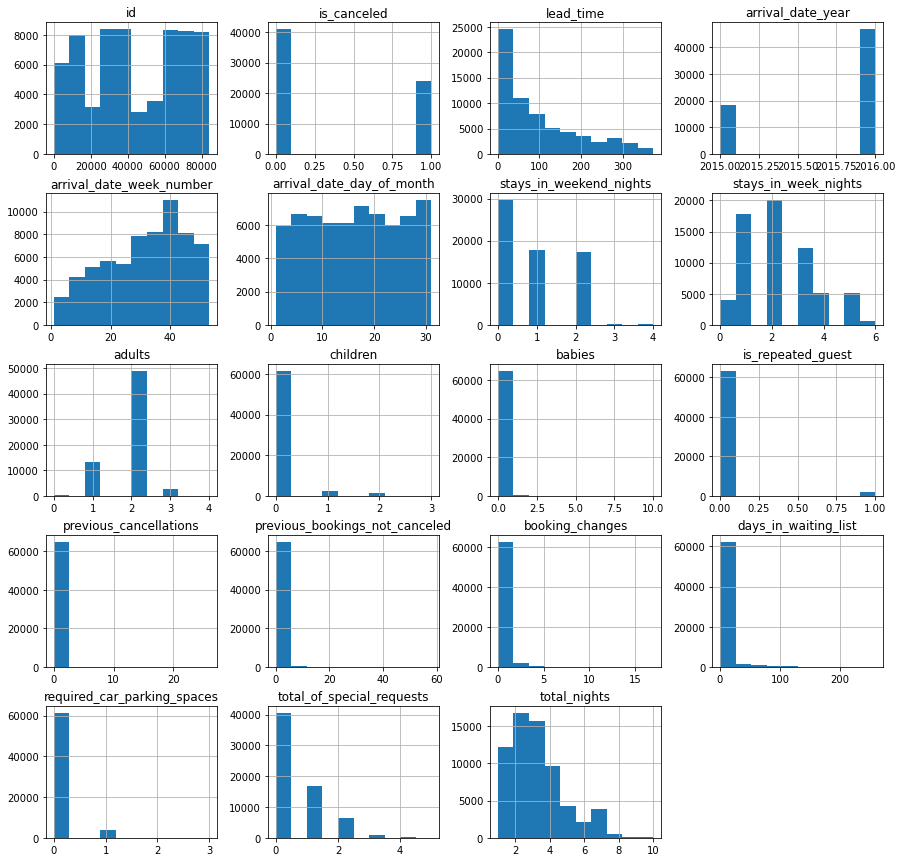

In [8]:
df.hist(figsize = (15, 15));

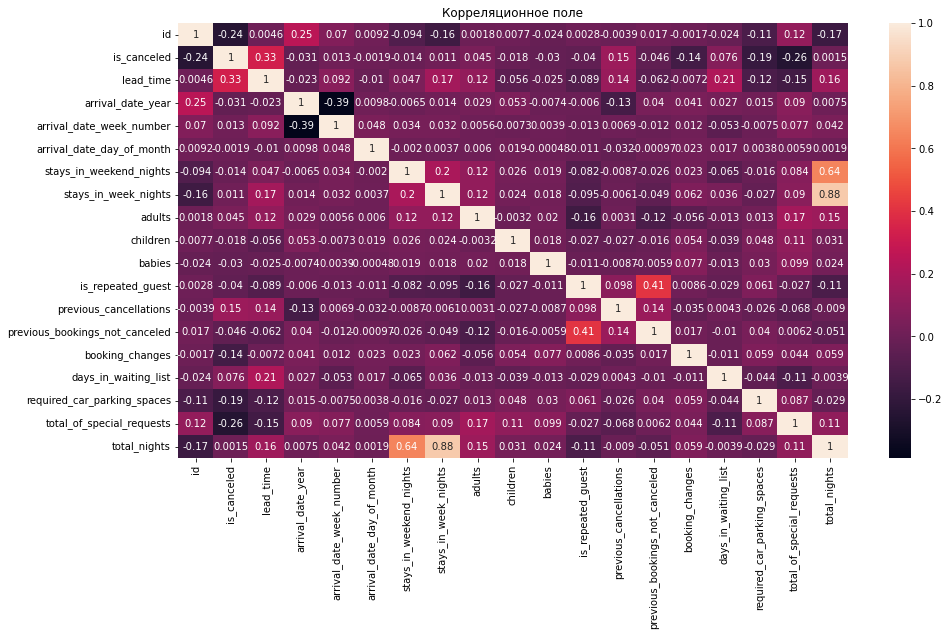

In [9]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot = True)
plt.title('Корреляционное поле')
plt.show()

In [10]:
!pip install phik

interval columns not set, guessing: ['id', 'is_canceled', 'lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights']


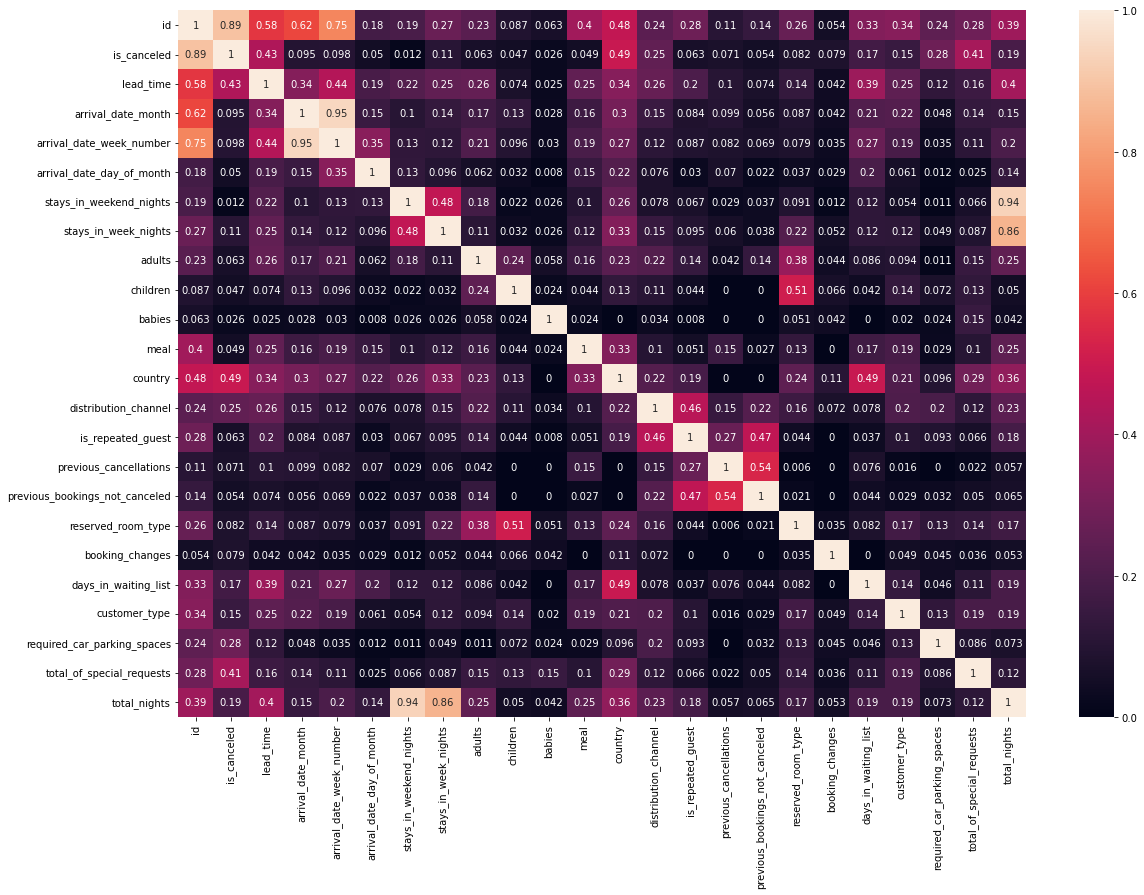

In [11]:
# для всех признаков

plt.figure(figsize=(19,13))
phik_overview = df.drop('arrival_date_year', axis = 1).phik_matrix()
sns.heatmap(phik_overview.round(3), annot = True)
plt.show()

In [12]:
old_shape = df.shape[0] # потом сравним сколько данных удалили
old_shape_test = df_test.shape[0]

# Вывод
Информация о данных получена, построенные гистограммы, график парных коэффициентов корреляции и выведена основная информация о каждом признаке в датасетах. Пропусков нет, с аномальными значениями будем разбираться дальше. Есть явная взаоимосвязть между total_nights и stays_in_week_nights, stays_in_weekend_nights

#  Предобработка и исследовательский анализ данных

Что я буду делалть?
- проверю есть ли в данных дупликаты
- удалю столбцы, которые не пригодятся в дальнейшей работе
- поменяю у некоторых столбцов тип данных
- рассмотрю каждый столбец отдельно


Весь анализ данных будет происходить на тренирочной выборке, а далее будут приняты решения, что менять в этой тренировочной выборке. После этого такие же действия будут проделаны с тестовой выборке

## Дубликаты

In [13]:
if ~df.duplicated().any():
    print('Дубликатов в тренировочной выборке нет')
else:
    print('Дубликаты есть')

Дубликатов в тренировочной выборке нет


In [14]:
if ~df_test.duplicated().any():
    print('Дубликатов в тестовой выборке нет')
else:
    print('Дубликаты есть')

Дубликатов в тестовой выборке нет


## Ненужные столбцы

In [15]:
df.arrival_date_year.value_counts()

2016    46901
2015    18328
Name: arrival_date_year, dtype: int64

In [16]:
df.arrival_date_week_number.unique()

array([27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26], dtype=int64)

In [17]:
df.arrival_date_day_of_month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int64)

In [18]:
df.total_nights.value_counts(normalize = True)

2     0.257478
3     0.239955
1     0.185838
4     0.147618
5     0.065738
7     0.059069
6     0.031857
8     0.008309
9     0.002330
10    0.001809
Name: total_nights, dtype: float64

In [19]:
df.distribution_channel.value_counts(normalize = True)

TA/TO        0.834813
Direct       0.105061
Corporate    0.058609
GDS          0.001518
Name: distribution_channel, dtype: float64

* id - для всех разный, не поможет в обучении модели


* arrival_date_year - всего два года, для следующих лет эта информация бесполезна


* arrival_date_week_number - большая вариация выбора, далее создам просто колонку с сезоном года


* arrival_date_day_of_month - день месяца будет бесполезен в обучении модели, так как информация изменяется в днях не из-за самих дней, а из-за сезоона


* total_nights - не нужен, так как есть кол-во ночей в рабочие и выходные дни


* distribution_channel - то, откуда перешел покупатель или где конкретно купил билеты, не влияет на его отмену броирования

In [20]:
df = df.drop(['id','arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month',
             'total_nights', 'distribution_channel'], axis = 1)

df_test = df_test.drop(['id','arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month',
             'total_nights', 'distribution_channel'], axis = 1)

## Тип данных

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     65229 non-null  int64  
 1   lead_time                       65229 non-null  float64
 2   arrival_date_month              65229 non-null  object 
 3   stays_in_weekend_nights         65229 non-null  int64  
 4   stays_in_week_nights            65229 non-null  int64  
 5   adults                          65229 non-null  float64
 6   children                        65229 non-null  float64
 7   babies                          65229 non-null  float64
 8   meal                            65229 non-null  object 
 9   country                         65229 non-null  object 
 10  is_repeated_guest               65229 non-null  int64  
 11  previous_cancellations          65229 non-null  int64  
 12  previous_bookings_not_canceled  

In [22]:
# переведем из вещественного типа в целочисленный
df[['lead_time','adults', 'children','babies']] = df[['lead_time','adults', 'children', 'babies']].astype(int)
df_test[['lead_time','adults', 'children','babies']] = df_test[['lead_time','adults', 'children', 'babies']].astype(int)

## Информация о признаках

### отменен ли заказ

In [23]:
df.is_canceled.value_counts()

0    41185
1    24044
Name: is_canceled, dtype: int64

### кол-во дней между бронированием и прибытием

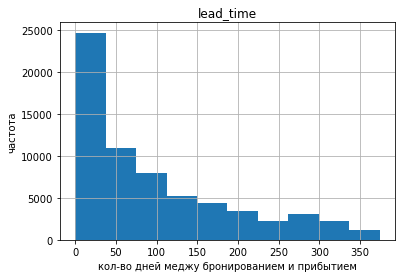

In [24]:
df.hist('lead_time');
plt.xlabel('кол-во дней меджу бронированием и прибытием')
plt.ylabel('частота')
plt.show()

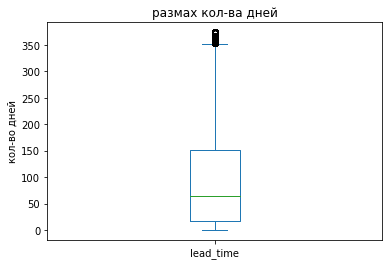

In [25]:
df['lead_time'].plot(kind = 'box', title = 'размах кол-ва дней', ylabel = 'кол-во дней');

In [26]:
iqr = df.lead_time.quantile(0.75) + 1.5 * iqr(df.lead_time)
print('IQR данных о количестве дней между броированием и прибытием равно',
      iqr)

IQR данных о количестве дней между броированием и прибытием равно 352.0


In [27]:
df = df.query('lead_time <= @iqr') # удалим выбросы, которые находятся за "усиками"
df_test = df_test.query('lead_time <= @iqr')

### месяц прибытия

In [28]:
df.arrival_date_month.unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [29]:
print(df.arrival_date_month.value_counts())

October      8880
September    8772
August       6677
November     5756
July         5653
December     5492
April        4804
May          4677
June         4627
March        4148
February     3358
January      1892
Name: arrival_date_month, dtype: int64


In [30]:
# функция для опредлеения времени года
def season(month):
    if month == 'October' or month == 'September' or month == 'November':
        return 'autumn'
    if month == 'August' or month == 'July' or month == 'June':
            return 'summer'
    if month == 'April' or month == 'May' or month == 'March':
        return 'spring'
    if month == 'January' or month == 'February' or month == 'December':
        return 'winter'
df['season'] = df['arrival_date_month'].apply(season)
df_test['season'] = df_test['arrival_date_month'].apply(season)

In [31]:
df.head(4)

,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,season
0,0,7,July,0,1,1,0,0,BB,GBR,0,0,0,A,0,0,Transient,0,0,summer
1,0,14,July,0,2,2,0,0,BB,GBR,0,0,0,A,0,0,Transient,0,1,summer
2,0,0,July,0,2,2,0,0,BB,PRT,0,0,0,C,0,0,Transient,0,0,summer
3,0,9,July,0,2,2,0,0,FB,PRT,0,0,0,C,0,0,Transient,0,1,summer


In [32]:
df.season.value_counts()

autumn    23408
summer    16957
spring    13629
winter    10742
Name: season, dtype: int64

### кол-во ночей в выходные в отеле

In [33]:
print(df.stays_in_weekend_nights.value_counts())

0    29467
1    17556
2    17305
3      260
4      148
Name: stays_in_weekend_nights, dtype: int64


Так как мы видели значение total_nights в 10 ночей, то это возможно, что человек остался на 4 ночи в выходные дни, на одной недели и на следующей

### кол-во ночей в будние дни

In [34]:
print(df.stays_in_week_nights.value_counts())

2    19903
1    17707
3    12315
5     5116
4     5081
0     3987
6      627
Name: stays_in_week_nights, dtype: int64


Так как мы видели значения total_nights равное 10, то это возможно, что человек оставался на 6 ночей в рабочие дни, просто начиналась другая неделя

In [35]:
df[(df['stays_in_week_nights'] == 0) & (df['stays_in_weekend_nights'] == 0)] # когда ни разу не ночевал

,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,season


### кол-во взрослых

In [36]:
df.adults.value_counts()

2    48535
1    13166
3     2856
0      166
4       13
Name: adults, dtype: int64

In [37]:
df[(df['adults'] == 0)] 

,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,season
17540,0,1,August,1,1,0,3,0,BB,PRT,0,0,0,B,1,0,Transient-Party,0,0,summer
17598,0,104,August,0,3,0,2,0,BB,FRA,0,0,0,B,1,0,Transient-Party,0,2,summer
17982,0,3,August,2,0,0,2,0,BB,PRT,0,0,0,B,1,0,Transient-Party,0,1,summer
21556,1,48,October,1,3,0,2,0,BB,PRT,0,0,0,B,0,0,Transient-Party,0,1,autumn
22516,1,6,December,1,0,0,3,0,BB,PRT,0,0,0,B,0,0,Transient-Party,0,1,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64751,0,197,December,1,4,0,3,0,HB,FRA,0,0,0,A,7,0,Transient-Party,0,0,winter
64882,0,104,December,2,1,0,2,0,BB,PRT,0,0,0,B,1,0,Transient,0,2,winter
64892,0,104,December,2,1,0,2,0,BB,FRA,0,0,0,B,0,0,Transient,0,2,winter
64903,0,247,December,2,3,0,2,0,BB,PRT,0,0,0,B,0,0,Transient,0,1,winter


Такие объекты невозможны, возможно была ошибка в заполнении анкеты. Забронировать комнату не взрослый не мог.

In [38]:
df = df.query('adults != 0') # удалим такие объекты
df_test = df_test.query('adults != 0')

### кол-во детей

In [39]:
df.children.value_counts()

0    61204
1     2163
2     1195
3        8
Name: children, dtype: int64

### кол-во младенцев

In [40]:
df.babies.value_counts()

0     64122
1       443
2         3
10        1
9         1
Name: babies, dtype: int64

In [41]:
df = df.query('babies < 9') # скорее всего значения в 9 и 10 были выставлены по ошибке
df_test = df_test.query('babies < 9')

### опции заказа

In [42]:
df.meal.value_counts()

BB           51128
HB            7212
SC            5262
SC             515
FB             451
Name: meal, dtype: int64

In [43]:
df.meal.unique() # надо избавиться от пробелов в значениях

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

In [44]:
df['meal'] = df['meal'].str.strip() # функция для удаления пробелов из строк
df_test['meal'] = df_test['meal'].str.strip()

### страна

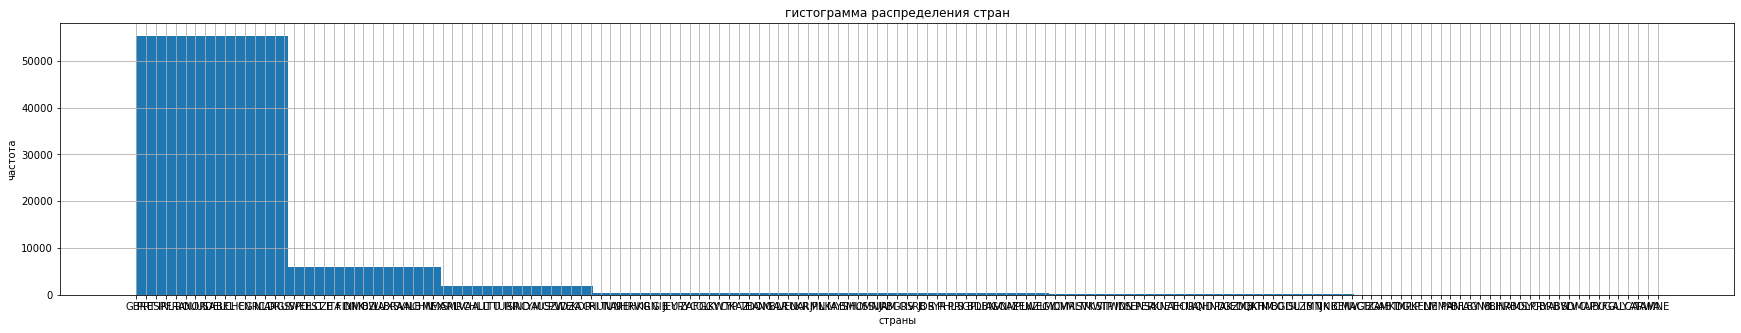

In [45]:
df['country'].hist(figsize = (30, 5))
plt.xlabel('страны')
plt.ylabel('частота')
plt.title('гистограмма распределения стран')
plt.show()

In [46]:
df.country.sort_values().unique()

array(['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATA', 'AUS',
       'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR',
       'BIH', 'BLR', 'BOL', 'BRA', 'BRB', 'BWA', 'CHE', 'CHL', 'CHN',
       'CIV', 'CMR', 'CN', 'COL', 'CPV', 'CRI', 'CUB', 'CYM', 'CYP',
       'CZE', 'DEU', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP',
       'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GEO', 'GGY', 'GIB',
       'GLP', 'GNB', 'GRC', 'GUY', 'HKG', 'HND', 'HRV', 'HUN', 'IDN',
       'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM',
       'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KHM', 'KNA', 'KOR', 'KWT',
       'LBN', 'LBY', 'LCA', 'LIE', 'LKA', 'LTU', 'LUX', 'LVA', 'MAC',
       'MAR', 'MCO', 'MDV', 'MEX', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE',
       'MOZ', 'MUS', 'MWI', 'MYS', 'NAM', 'NGA', 'NIC', 'NLD', 'NOR',
       'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'PLW', 'POL', 'PRI',
       'PRT', 'PRY', 'PYF', 'QAT', 'ROU', 'RUS', 'RWA', 'SAU', 'SEN',
       'SGP', 'SLV', 

In [47]:
df.country.value_counts()

PRT    28387
FRA     5956
GBR     5037
ESP     4887
DEU     3866
       ...  
IMN        1
NIC        1
BEN        1
VGB        1
STP        1
Name: country, Length: 155, dtype: int64

Есть редкие страны. Идея - объединить такие страныв одну категорию - "другие", которые встречаются реже 50 раз.

In [48]:
comb = pd.DataFrame(df.country.value_counts()).query('country <= 50').index # страны, которые встречаеются меньше 50 раз

comb2 = pd.DataFrame(df_test.country.value_counts()).query('country <= 50').index

In [49]:
def coun(row): # функция для смены редкй страны на категорию 'other'
    if row in comb or row in comb2:
        return 'other'
    return row
df.country = df.country.apply(coun)
df_test.country = df_test.country.apply(coun)

In [50]:
df.country.value_counts()

PRT      28387
FRA       5956
GBR       5037
ESP       4887
DEU       3866
ITA       2319
other     1790
IRL       1440
BEL       1227
NLD       1153
BRA       1083
USA       1005
CHE        866
AUT        714
SWE        541
POL        529
CHN        525
CN         488
ISR        375
RUS        292
NOR        261
ROU        247
FIN        239
DNK        199
TUR        168
AUS        168
AGO        140
LUX        132
MAR        123
HUN        121
JPN        117
ARG        106
KOR         67
Name: country, dtype: int64

### бронировали ли раньше

In [51]:
df.is_repeated_guest.value_counts()

0    62804
1     1764
Name: is_repeated_guest, dtype: int64

### отменяли ли раньше

In [52]:
df.previous_cancellations.value_counts()

0     59229
1      5069
2        53
3        51
11       35
24       28
25       19
26       18
19       17
5        13
13       12
14       11
6         7
4         5
21        1
Name: previous_cancellations, dtype: int64

может сказать многое о покупателе, поэтому оставим как есть

### кол-во неотмененных заказов

In [53]:
df.previous_bookings_not_canceled.value_counts()

0     63028
1       643
2       252
3       136
4       114
5        89
6        56
7        34
8        25
9        23
10       20
11       16
12       14
25       10
13        9
21        8
14        8
22        7
15        7
16        6
18        5
17        5
19        5
20        5
24        3
27        3
44        2
48        2
29        2
28        2
23        2
57        1
56        1
55        1
54        1
53        1
52        1
58        1
51        1
50        1
49        1
47        1
45        1
37        1
43        1
42        1
41        1
40        1
39        1
38        1
36        1
35        1
34        1
33        1
32        1
31        1
26        1
30        1
Name: previous_bookings_not_canceled, dtype: int64

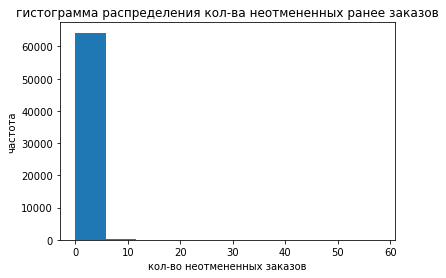

In [54]:
df['previous_bookings_not_canceled'].plot(kind = 'hist')
plt.xlabel('кол-во неотмененных заказов');
plt.ylabel('частота')
plt.title('гистограмма распределения кол-ва неотмененных ранее заказов')
plt.show();

In [55]:
df = df.query('previous_bookings_not_canceled <= 25') # считаю, что важный показатель, а число неомененных заказов в 25
# выглядит реально
df_test = df_test.query('previous_bookings_not_canceled <= 25')

### тип комнаты

In [56]:
df.reserved_room_type.value_counts()

A                   49971
D                    9379
E                    2437
F                    1211
B                     713
G                     591
C                     228
Name: reserved_room_type, dtype: int64

In [57]:
df.reserved_room_type.unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

In [58]:
df['reserved_room_type'] = df['reserved_room_type'].str.strip() # удялим пробелы
df_test['reserved_room_type'] = df_test['reserved_room_type'].str.strip() 

### кол-во изменений заказа

In [59]:
df.booking_changes.value_counts()

0     55636
1      6525
2      1728
3       393
4       148
5        41
6        18
7        17
8         7
9         5
13        4
10        2
14        2
15        2
16        1
17        1
Name: booking_changes, dtype: int64

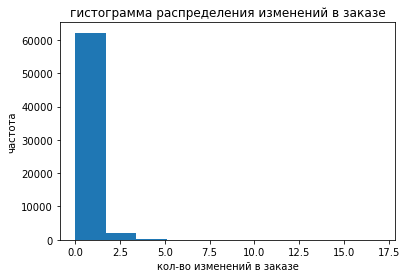

In [60]:
df['booking_changes'].plot(kind = 'hist')
plt.xlabel('кол-во изменений в заказе');
plt.ylabel('частота')
plt.title('гистограмма распределения изменений в заказе')
plt.show();

In [61]:
df = df.query('booking_changes <= 5')
df_test = df_test.query('booking_changes <= 5') 

### кол-во дней ожидания подтверждения

In [62]:
df.days_in_waiting_list.sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   8,   9,  10,  11,  12,  13,
        14,  15,  17,  19,  20,  21,  22,  24,  25,  27,  28,  30,  31,
        32,  33,  34,  35,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  53,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  65,  68,  69,  70,  71,  72,  74,  75,  76,  77,  79,  80,
        81,  85,  87,  89,  91,  93,  96,  98,  99, 101, 107, 108, 111,
       120, 122, 125, 142, 147, 150, 160, 162, 167, 174, 176, 178, 187,
       193, 207, 215, 224, 236, 259], dtype=int64)

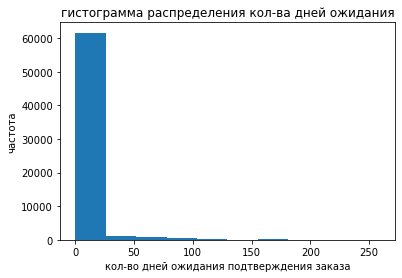

In [63]:
df['days_in_waiting_list'].plot(kind = 'hist')
plt.xlabel('кол-во дней ожидания подтверждения заказа')
plt.ylabel('частота')
plt.title('гистограмма распределения кол-ва дней ожидания')
plt.show();

In [64]:
df = df.query('days_in_waiting_list < 100') # важный признак, поэтому ставлю большое значние, никому не хочется ожидать свое 
# # подтверждение слишком долго 
df_test = df_test.query('days_in_waiting_list < 100')

### тип заказчика

In [65]:
df.customer_type.value_counts()

Transient          45003
Transient-Party    16008
Contract            2622
Group                281
Name: customer_type, dtype: int64

### кол-во мест для парковки

In [66]:
df.required_car_parking_spaces.value_counts()

0    60254
1     3648
2       11
3        1
Name: required_car_parking_spaces, dtype: int64

### кол-во специальных отметок

In [67]:
df.total_of_special_requests.value_counts()

0    39570
1    16802
2     6400
3     1025
4      104
5       13
Name: total_of_special_requests, dtype: int64

In [68]:
print(f"Было удалено {(old_shape / df.shape[0] - 1):.3%} данных в тренировочной выборке")
print(f"Было удалено {(old_shape_test / df_test.shape[0] - 1):.3%} данных в тестовой выборке")

Было удалено 2.057% данных в тренировочной выборке
Было удалено 0.906% данных в тестовой выборке


# Вывод

__Все признаки посмотрели, от всех аномальных значений избавились.__


* тип данных в столбцах 'lead_time','adults', 'children','babies' был изменен



* ненужные столбцы  'id','arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'total_nights', 'distribution_channel' были удалены


* данные проверены на дубликаты, дубаликатов не обнаружено


* удалены значения кол-ва дней между прибытием и бронированием большие 352


* были добавлены времена года в датасет


* строки, где кол-во взрослых было равно 0, были удалены


* строки с кол-вом детей со значениями 9 и 10 были удалдены


* из значений опций заказов и типа комнаты были удалены лишние пробелы


* страны, встречающиеся реже 50 раз, были объеденены в одну категорию - "Другие"


* значения неотмененных заказов, превышающие частоту в 25, были удалены


* были оставлены значения меньше 5 в признаке "изменения в заказе"


* значения более 100, в признаке "кол-во дней ожидание подтверждения" были удалены


Было удалено 2.057% данных в тренировочной выборке

Было удалено 0.906% данных в тестовой выборке

# Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Оценим прибыль отеля без внедрения депозитов

In [69]:
BUDGET = 400_000
rooms = pd.DataFrame({'A':[1000, 400],       # для каждого типа комнаты присвоим цену за ночь и за уборку
                     'B':[800, 350],
                     'C':[600, 350],
                     'D':[550, 150],
                     'E':[500, 150],
                     'F':[450, 150],
                     'G':[350, 150]}, index = ['night_price', 'service'])
season_ratio = pd.DataFrame({'summer':[1.4],   #   для каждого сезона присвоим коэффициент
                           'autumn':[1.2],
                           'spring':[1.2],
                            'winter':[1]}, index = ['ratio'])

In [70]:
def revenue(data):      # ффункция для подсчтеа прибыли
    room_type = data['reserved_room_type']
    season = data['season']
    total_nights = data['stays_in_week_nights'] + data['stays_in_weekend_nights']
    is_canceled = data['is_canceled']
    
    room_price = rooms[room_type].night_price
    service_price = rooms[room_type].service
    ratio_for_price = season_ratio[season].ratio
   
    
    if is_canceled:
        profit = -ratio_for_price * ( room_price) - service_price
    else:
        # если человек приехал на одну ночь, надо убраться только после его приезда для след. покупателя. 1 уборка 
        # Если на две ночи то убирают только после приезда для след. постояльца 1 уборка
        # Если три дня, то убирают каждый второй день, то есть 1 раз и после для след. покупателя 2 уборки
        # Если на 4 дня - то всего две уборки и так далее
        profit = ratio_for_price * (total_nights*room_price) - ((1 + total_nights) // 2) * service_price 
    
    
    return profit

total_revenue = df_test.apply(revenue, axis = 1).sum() - BUDGET

In [71]:
print('Прибыль отеля без внедрения депозитов равна ', total_revenue / 1000000, 'млн.руб.')

Прибыль отеля без внедрения депозитов равна  34.75935 млн.руб.


In [72]:
print('Значит прибыль с внедренияим депозитов должна быть >=', total_revenue / 1000000 + BUDGET / 1000000)

Значит прибыль с внедренияим депозитов должна быть >= 35.159349999999996


# Шаг 4. Разработка модели ML

In [73]:
df.head(2)

,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,season
0,0,7,July,0,1,1,0,0,BB,GBR,0,0,0,A,0,0,Transient,0,0,summer
1,0,14,July,0,2,2,0,0,BB,GBR,0,0,0,A,0,0,Transient,0,1,summer


In [74]:
df = df.drop('season', axis = 1) # удалим сезоны, так как у нас уже есть месяца
seasons = df_test['season']
df_test = df_test.drop('season', axis = 1)

In [75]:
features_train = df.drop('is_canceled', axis = 1)
target_train = df['is_canceled']


features_test = df_test.drop('is_canceled', axis = 1)
target_test = df_test['is_canceled']

In [76]:
obj_features = features_train.select_dtypes(include='object').columns.to_list()  # столбцы типа object
num_features = features_train.select_dtypes(exclude='object').columns.to_list()  # столбцы типа int or float
print('objects: \n', obj_features)
print('nums: \n', num_features)
# используем технику OneHotEncoder для работы с строковыми значениями
encoder = OneHotEncoder(handle_unknown = 'ignore',drop = 'first', sparse = False) 

encoder.fit(features_train[obj_features])

features_train[
    encoder.get_feature_names_out()
] = encoder.transform(features_train[obj_features])

features_train = features_train.drop(obj_features, axis = 1)


features_test[
    encoder.get_feature_names_out()
] = encoder.transform(features_test[obj_features])

features_test = features_test.drop(obj_features, axis = 1)

objects: 
 ['arrival_date_month', 'meal', 'country', 'reserved_room_type', 'customer_type']
nums: 
 ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests']


In [77]:
features_train.head(3)

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,country_ARG,country_AUS,country_AUT,country_BEL,country_BRA,country_CHE,country_CHN,country_CN,country_DEU,country_DNK,country_ESP,country_FIN,country_FRA,country_GBR,country_HUN,country_IRL,country_ISR,country_ITA,country_JPN,country_KOR,country_LUX,country_MAR,country_NLD,country_NOR,country_POL,country_PRT,country_ROU,country_RUS,country_SWE,country_TUR,country_USA,country_other,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,7,0,1,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,14,0,2,2,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,2,2,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [78]:
scaler = StandardScaler() # стандартизиуем данные
#scaler = MinMaxScaler()
scaler.fit(features_train[num_features])
features_train[num_features] = scaler.transform(features_train[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])

In [79]:
model = DecisionTreeClassifier(random_state = 99)
model.fit(features_train, target_train)
print('Максимальная глубина дерева равна', model.get_depth())

Максимальная глубина дерева равна 50


Проверим три модели для задачи классификации, метрику выберем f1, для того, чтобы учитывать одновременно и точноть модели и полноту

In [80]:
f = 0
cw = ['balanced', None]
for weight in cw:
    for depth in range(1, 11):
        for split in range(2, 7):
            for leaf in range(1, 7):
                    model = DecisionTreeClassifier(random_state = 99, max_depth = depth,
                                                  class_weight = weight, min_samples_split = split,
                                                  min_samples_leaf = leaf)
                    scores = cross_val_score(model,features_train, target_train, cv=5, scoring='f1')
                    final_score = sum(scores)/len(scores)
                    if final_score > f:
                        params_1 = model.get_params()
                        f = final_score                    
print('средняя оценка f1 качества модели:', f, 'при параметрах:')
print(params_1)

средняя оценка f1 качества модели: 0.6851646265072613 при параметрах:
{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 99, 'splitter': 'best'}


In [81]:
# features_train.reset_index(drop = True, inplace = True)
# target_train.reset_index(drop = True, inplace = True)
# sample_size = int(len(features_train)/ 6)
# scores = []
# k = 0
# from sklearn.utils import shuffle
# p = 0
# for i in range(0, len(features_train) - 5, sample_size):
#     valid_indexes = np.arange(i, i + sample_size).tolist()# < запишите массив из индексов для валидационного блока >
#     train_indexes = np.arange(0, i).tolist() + np.arange(i + sample_size, len(features_train)).tolist()# < запишите массив из индексов для обучающей выборки >

#     features_trains = features_train.loc[train_indexes]
#     features_valid = features_train.loc[valid_indexes]
#     target_trains = target_train.loc[train_indexes]
#     target_valid = target_train.loc[valid_indexes]
#     for d in range(1, 7):

#         model = DecisionTreeClassifier(random_state=99, max_depth = d, class_weight = 'balanced')
#         model = model.fit(features_trains, target_trains)
#         score = f1_score(target_valid, model.predict(features_valid))# < оцените качество модели >
#         p = d
#     scores.append([score, p])
    
# scores

In [82]:
f = 0
for depth in range(1, 11):
    for class_weight in cw:
        for estimators in (1, 500):
            model = RandomForestClassifier(
                random_state = 99, class_weight = class_weight, n_estimators = estimators,
                max_depth = depth)
            scores = cross_val_score(model, features_train, target_train, cv = 5, scoring = 'f1')
            final_score = sum(scores) / len(scores)
            if final_score > f :
                f = final_score
                params_2 = model.get_params()
print('средняя оценка f1 качества модели:', f, '   достигается при параметрах:')
print(params_2)

средняя оценка f1 качества модели: 0.6188107606042138    достигается при параметрах:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 99, 'verbose': 0, 'warm_start': False}


In [83]:
f = 0 
p = ['l1', 'l2']
for class_weight in cw:
    for penalty in p:
        for cc in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]:
            model = LogisticRegression(random_state = 99, max_iter = 500000, solver = 'liblinear', class_weight = class_weight,
                                      penalty = penalty, C = cc)
            scores = cross_val_score(model, features_train, target_train, cv = 5, scoring = 'f1')
            final_score = sum(scores) / len(scores)
            if final_score > f:
                f = final_score
                params_3 = model.get_params()
print('средняя оценка f1 модели:', f, '    при параметрах:')
print(params_3)

средняя оценка f1 модели: 0.6236922583151243     при параметрах:
{'C': 0.001, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 500000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 99, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


Лучшая модель, которая дала наивысший результат, по стравнению с сотальными, это DecisionTreeClassifeir, её и будем использовать для тестововй выборке с выбранныим параметрами

In [84]:
model = DecisionTreeClassifier(**params_1)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
predictions_prob = model.predict_proba(features_test)

f1 = f1_score(target_test, predictions)
auc_roc = roc_auc_score(target_test, predictions_prob[:, 1])
accuracy = accuracy_score(target_test, predictions)

print('f1', f1)
print('auc-roc', auc_roc)
print('accuracy', accuracy)

f1 0.6545440355874663
auc-roc 0.7888394002336064
accuracy 0.7243859157560475


In [85]:
df_test['predictions'] = predictions # сохраним наши предсказания в столбцев с предсказаниями

In [86]:
df_test.head(3)

,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,predictions
0,1,74,January,1,0,2,0,0,BB,PRT,0,0,0,A,0,0,Transient,0,0,1
1,1,62,January,2,2,2,0,0,BB,AUT,0,0,0,A,0,0,Transient,0,1,0
2,1,62,January,2,2,2,0,0,BB,AUT,0,0,0,A,0,0,Transient,0,1,0


Проверим метрики на "глупой модели"

In [87]:
dummy_classifier = DummyClassifier(strategy = 'most_frequent')
dummy_classifier.fit(features_train, target_train)
test_predictions = dummy_classifier.predict(features_test)
test_proba = dummy_classifier.predict_proba(features_test)[:, 1]

accuracy_d = accuracy_score(target_test, test_predictions)
f1_d = f1_score(target_test, test_predictions )
auc_roc_d = roc_auc_score(target_test, test_proba)

print('f1', f1_d)
print('auc-roc', auc_roc_d)
print('accuracy', accuracy_d)

f1 0.0
auc-roc 0.5
accuracy 0.6129323495532518


Как видим, метрики хуже, чем на нашей выбранной модели,поэтому можем с ней работать 

Теперь, используя ранее написанную функцию для подсчета прибыли, посчитаем столько нам получится заработать с приминением депозитов

In [88]:
def revenue(data):
    deposit_ratio = 0.8
    deposit = 0
    room_type = data['reserved_room_type']
    season = data['season']
    total_nights = data['stays_in_week_nights'] + data['stays_in_weekend_nights']
    is_canceled = data['is_canceled']
    predicted_cancellation = data['predictions']
    
    room_price = rooms[room_type].night_price
    service_price = rooms[room_type].service
    ratio_for_price = season_ratio[season].ratio
    
    if predicted_cancellation:
        deposit = deposit_ratio * (room_price * ratio_for_price + service_price)
        
       
    if is_canceled:
        profit = deposit - ratio_for_price * room_price - service_price
    else:
        profit = ratio_for_price * (total_nights*room_price) - ((1 + total_nights) // 2) * service_price 
        

    return profit


df_test['season'] = seasons
total_revenue_with_deposits = df_test.apply(revenue, axis = 1).sum() * 12 / 8 - BUDGET

In [89]:
print('с депозитами прибыль стала равна', total_revenue_with_deposits / 1000000 , 'млн.руб')

с депозитами прибыль стала равна 66.957137 млн.руб


In [90]:
print('прибыль увеличилась после внедрения депозитов на ', (total_revenue_with_deposits - total_revenue) / 1000000, 'млн.руб')

прибыль увеличилась после внедрения депозитов на  32.197787 млн.руб


# Вывод:

Для обработки данных я использовал две методики: OneHotEncoder и StandardScaler. Было проверено 3 модели классификации, для кажждой были проверены параметры и выбраны лучшие. 

Лучшая модель - DecisionTreeClassifier. 

Ее параметры - {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 99, 'splitter': 'best'}


- С выбранной модльею и параметрами, я посчитал метриик на тестовой выборке, результат:
\
1) f1 = 0.6545440355874663
\
2) auc-roc = 0.7888394002336064
\
3) accuracy = 0.7243859157560475


- Была проверена "глупая" модель с методикой наичастешейго целевого признака, результаты: 
\
1) f1 = 0.0
\
2) auc-roc = 0.5
\
3) accuracy = 0.6129323495532518


С внедрением депозитов прибыль стала равна 44.504758 млн.руб, что больше на 9.745408 млн.руб, чем прибыль отеля без депозитов.

# Описание портрет «ненадёжного» клиента

In [91]:
df_test.query('is_canceled == 1 and predictions == 1').describe(include = 'all')

,is_canceled,lead_time,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,predictions,season
count,8387.0,8387.000000,8387,8387.000000,8387.000000,8387.000000,8387.000000,8387.000000,8387,8387,8387.000000,8387.000000,8387.000000,8387,8387.000000,8387.000000,8387,8387.0,8387.000000,8387.0,8387
unique,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,4,33,NaN,NaN,NaN,7,NaN,NaN,4,NaN,NaN,NaN,3
top,NaN,NaN,May,NaN,NaN,NaN,NaN,NaN,BB,PRT,NaN,NaN,NaN,A,NaN,NaN,Transient,NaN,NaN,NaN,spring
freq,NaN,NaN,1636,NaN,NaN,NaN,NaN,NaN,6888,5078,NaN,NaN,NaN,6549,NaN,NaN,7767,NaN,NaN,NaN,4200
mean,1.0,125.372958,NaN,0.854656,2.387624,1.894718,0.075712,0.001192,NaN,NaN,0.001669,0.003100,0.010731,NaN,0.048885,0.400382,NaN,0.0,0.079409,1.0,NaN
std,0.0,77.634224,NaN,0.858303,1.274829,0.455776,0.335676,0.034511,NaN,NaN,0.040825,0.087305,0.331406,NaN,0.311929,4.465539,NaN,0.0,0.331060,0.0,NaN
min,1.0,5.000000,NaN,0.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.0,0.000000,1.0,NaN
25%,1.0,59.000000,NaN,0.000000,1.000000,2.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.0,0.000000,1.0,NaN
50%,1.0,115.000000,NaN,1.000000,2.000000,2.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.0,0.000000,1.0,NaN
75%,1.0,174.000000,NaN,2.000000,3.000000,2.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.0,0.000000,1.0,NaN


In [92]:
import pprint
for col in obj_features:
    print(col)
    print(df_test.query('is_canceled == 1 and predictions == 1')[col].value_counts(normalize = True), '\n')

arrival_date_month
May         0.195064
April       0.184094
June        0.174198
March       0.121617
July        0.087397
February    0.083224
January     0.081436
August      0.072970
Name: arrival_date_month, dtype: float64 

meal
BB    0.821271
SC    0.123763
HB    0.053535
FB    0.001431
Name: meal, dtype: float64 

country
PRT      0.605461
GBR      0.058901
FRA      0.051270
DEU      0.038989
ITA      0.033266
ESP      0.031120
BRA      0.020508
IRL      0.019316
other    0.016454
CHN      0.014546
BEL      0.013950
USA      0.013950
CHE      0.010731
NLD      0.010254
NOR      0.007750
AUT      0.007273
CN       0.005723
DNK      0.004889
SWE      0.004412
POL      0.003696
RUS      0.003696
AUS      0.003577
ISR      0.003219
ROU      0.002981
LUX      0.002862
KOR      0.002265
FIN      0.001669
TUR      0.001550
HUN      0.001431
MAR      0.001312
ARG      0.001192
AGO      0.001192
JPN      0.000596
Name: country, dtype: float64 

reserved_room_type
A    0.780851
D    0.15

#  Итак, описание "ненадежного клиента":

- Бронирует примерно за 125 дней до прибытия в отель.


- остается примерно на 1 ночь в выходные и на две ночи в рабочие дни.


- Количество взрослых постояльцев в среднем равно 2, без детей и младенцев.


- Он не был раньше в этом отеле, поэтому значения признаков отмененных предыдущих заказов и неотмененных заказов стремиться к нулю.


- Он совсем не вносит изменений в свой заказ.


- В среднем ожидает заказа 0 или 1 день.


- Ему не нужно порковочное место.


- Не делает специальные отметки


- Обычно бронирует номер на май или апрель.


- Чаще всего у него включен завтрак в заказе номера.


- Обычно этот покупатель из Португалии


- Он заказывает самый дорогой тип комнат - А


- Его тип не связан с договором или с групповым заездом.

# Вывод: 

* **Данные были обработаны, ненужные столбцы были удалены('id','arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'total_nights', 'distribution_channel'). Избавились от аномальных значний в признаках.**


* __Прибыль без депозитов составляет 34.75935 млн.руб.__


* __Выбрана лучшая модель и лучшие параметры для нее. Модель - DecisionTreeClassifeir. С данной моделью были внедрены депозиты, с помощью них выручка отлея увеличилась на 9.745408 млн.руб, что равно 44.504758 млн.руб.__


* __Я дал подробное описание "ненадежного клиента".__

__С сситемой депозитом прибыль явно выросла, поэтому данная методика имеет место быть и применяться в бизнесе.__